In [ ]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import random
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
t = torch.tensor([[[1.0], [2.0], [3.0]]])  # Shape: (1, 3, 1)
t_squeezed = t.squeeze(dim=0)
t_squeezed

tensor([[1.],
        [2.],
        [3.]])

In [ ]:
from google.colab import drive
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


https://s32.picofile.com/d/8480811684/3a7cf6b9-4392-4132-bae2-4be5fb405ca3/fair_face_with_labels.rar

In [ ]:
trn_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class6-Tahlildadeh/fairface-label-train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class6-Tahlildadeh/fairface-label-val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


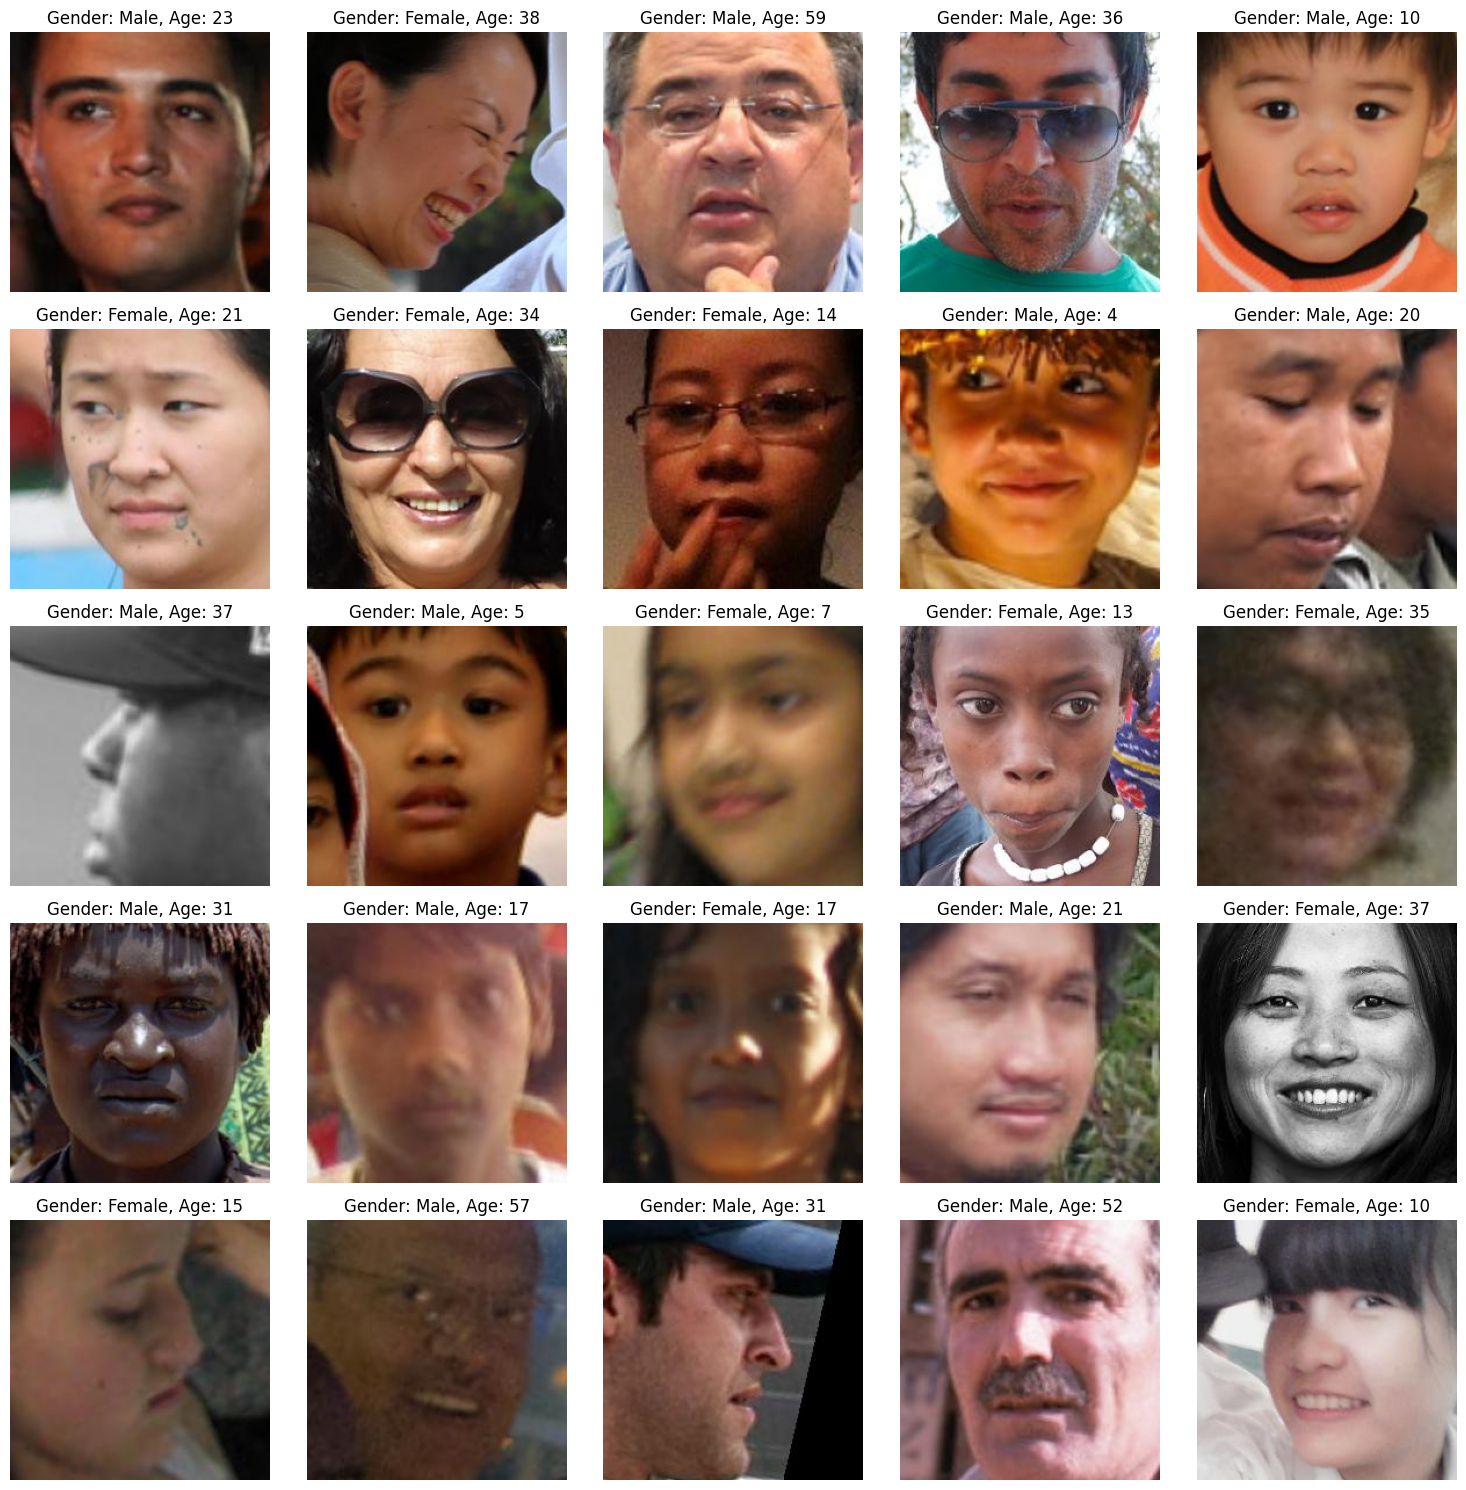

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Update the base directory path where images are stored
base_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class6-Tahlildadeh/Fairface_extracted/'

# Prepend the base path to the relative paths in the 'file' column
test_df = val_df.copy()
test_df['file'] = test_df['file'].apply(lambda x: os.path.join(base_path, x))

# Select random images
images = random.choices(test_df.file, k=25)

# Create a 5x5 subplot grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for ax, image_file in zip(axes, images):
    try:
        # Load the image
        image = Image.open(image_file)

        # Get the corresponding gender and age
        gender = test_df.loc[test_df['file'] == image_file, 'gender'].values[0]
        age = test_df.loc[test_df['file'] == image_file, 'age'].values[0]

        # Plot the image
        ax.imshow(image)
        ax.set_title(f'Gender: {gender}, Age: {age}')
    except FileNotFoundError:
        ax.set_title("File not found")
    except Exception as e:
        ax.set_title(f"Error: {e}")
    finally:
        ax.axis('off')  # Hide axes for missing files or errors

# Adjust the layout
plt.tight_layout()
plt.show()


In [ ]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = float(f.gender == 'Female')
        age = float(f.age/80)
        gen = torch.tensor(gen, dtype=torch.float32)
        age = torch.tensor(age, dtype=torch.float32)
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im, age, gen



In [ ]:
# Update the base directory path where images are stored
base_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class6-Tahlildadeh/Fairface_extracted/'

# Prepend the base path to the relative paths in the 'file' column
val_df = val_df.copy()
val_df['file'] = val_df['file'].apply(lambda x: os.path.join(base_path, x))

# Prepend the base path to the relative paths in the 'file' column
trn_df = trn_df.copy()
trn_df['file'] = trn_df['file'].apply(lambda x: os.path.join(base_path, x))

In [ ]:
train_dataset = GenderAgeClass(trn_df)
valid_dataset = GenderAgeClass(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle= False)

In [ ]:
a,b,c, = next(iter(train_dataloader))
print(a.shape, b.shape, c.shape)

In [ ]:
plt.imshow(a[10].numpy().transpose(1,2,0))

In [ ]:
def get_model():
    # model = models.vgg16(pretrained=True)
    model = models.vgg16(pretrained=True).to(device)
    # model_path = "vgg16_model.pth"
    # model.load_state_dict(torch.load(model_path, map_location=device))
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                # nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

# model, loss_functions, optimizer = get_model()

In [ ]:
model = models.vgg16(pretrained=True).to(device)
model_path = "vgg16_model.pth"


In [ ]:
model.avgpool

In [ ]:
model

In [ ]:
from torchsummary import summary

# Example: Your model and input size
input_size = (3, 224, 224)  # For a 3-channel image
summary(model, input_size)


In [ ]:
def get_model():
    # model = models.vgg16(pretrained=True)
    model = models.vgg16(pretrained=True).to(device)
    # model_path = "vgg16_model.pth"
    # model.load_state_dict(torch.load(model_path, map_location=device))
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                # nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

model, loss_fn, optimizer = get_model() #loss_fn is tuple

def accuracy(outputs, targets):
    prediction = (outputs > 0.5).float()
    targets = targets.float()
    is_correct = (prediction == targets).float()
    return is_correct.mean().item()


def train(model, dataloader, optimizer,criteria):
    model.train()
    total_loss_epoch = 0.0
    gender_acc = 0.0
    age_mae = 0.0
    for im, age, gender in dataloader:
        optimizer.zero_grad()
        im, age, gender = im.to(device), age.to(device), gender.to(device)
        pred_gender, pred_age = model(im)
        gender_criterion, age_criterion = criteria
        gender_loss = gender_criterion(pred_gender.squeeze(), gender)
        age_loss = age_criterion(pred_age.squeeze(), age)
        total_loss_batch = gender_loss + age_loss
        total_loss_batch.backward()
        optimizer.step()
        total_loss_epoch += total_loss_batch.item()
        gender_acc += accuracy(pred_gender, gender)
        age_mae += torch.abs(age - pred_age.squeeze()).float().sum()
    return total_loss_epoch / len(dataloader), gender_acc / len(dataloader), age_mae/len(dataloader)

def validate(model, dataloader, criteria):
    model.eval()
    total_loss_epoch = 0.0
    gender_acc = 0.0
    age_mae = 0.0
    with torch.no_grad():
         for im, age, gender in dataloader:
            im, age, gender = im.to(device), age.to(device), gender.to(device)
            pred_gender, pred_age = model(im)
            gender_criterion, age_criterion = criteria
            gender_loss = gender_criterion(pred_gender.squeeze(), gender)
            age_loss = age_criterion(pred_age.squeeze(), age)
            total_loss_batch = gender_loss + age_loss
            total_loss_epoch += total_loss_batch.item()
            gender_acc += accuracy(pred_gender, gender)
            age_mae += (torch.abs(age - pred_age.squeeze()).float()).sum()
    return total_loss_epoch / len(dataloader), gender_acc / len(dataloader), age_mae/len(dataloader)





In [ ]:
val_gender_accuracies = []
train_gender_accuracies = []
train_age_maes = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 10
best_test_loss = 1000
start = time.time()
for epoch in range(n_epochs):
    train_loss, gender_acc, age_mae = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_gender_accuracies.append(gender_acc)
    train_age_maes.append(age_mae)

    valid_loss, gender_acc, age_mae = validate(model, valid_dataloader, loss_fn)
    val_losses.append(valid_loss)
    val_gender_accuracies.append(gender_acc)
    val_age_maes.append(age_mae)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, "
          f"Train Accuracy: {gender_acc:.4f}, Validation Accuracy: {gender_acc:.4f}, "
          f"Train Age MAE: {age_mae:.4f}, Validation Age MAE: {age_mae:.4f}")


In [ ]:
model_path = "vgg16_model_age_gender.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import random
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
device

In [ ]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = float(f.gender == 'Female')
        age = float(f.age/80)
        gen = torch.tensor(gen, dtype=torch.float32)
        age = torch.tensor(age, dtype=torch.float32)
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im, age, gen

train_dataset = GenderAgeClass(trn_df)
valid_dataset = GenderAgeClass(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle= False)
print('dataloder defined in training dataset and valid dataset')

def get_model():
    # model = models.vgg16(pretrained=True).to(device)
    model = models.vgg16(pretrained=False).to(device)
    model_path = "vgg16_model.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    print('model loaded')
    for param in model.parameters():
        param.requires_grad = False
    print('model is freezed')
    model.avgpool = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size = (7,7)),
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.7),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.7),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(32, 1),
                # nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    print('model definition comlete')
    return model.to(device), loss_functions, optimizer

model, loss_fn, optimizer = get_model() #loss_fn is tuple

def accuracy(outputs, targets):
    # print((outputs == targets).float().sum())
    return (outputs == targets).float().sum()



def train(model, dataloader, optimizer,criteria):
    model.train()
    total_loss_epoch = 0.0
    gender_acc = 0.0
    age_mae = 0.0
    ctr = 0.0
    for im, age, gender in dataloader:
        optimizer.zero_grad()
        im, age, gender = im.to(device), age.to(device), gender.to(device)
        pred_gender, pred_age = model(im)
        gender_criterion, age_criterion = criteria
        gender_loss = gender_criterion(pred_gender.squeeze(), gender)
        age_loss = age_criterion(pred_age.squeeze(), age)
        total_loss_batch = gender_loss + age_loss
        total_loss_batch.backward()
        optimizer.step()
        total_loss_epoch += total_loss_batch.item()
        pred_gender = (pred_gender > 0.5).squeeze().float()
        gender_acc += accuracy(pred_gender, gender)
        age_mae += torch.abs(age - pred_age.squeeze()).float().sum().item()
        ctr += 1
    return total_loss_epoch / len(dataloader), gender_acc / (ctr*32), age_mae/len(dataloader)

def validate(model, dataloader, criteria):
    model.eval()
    total_loss_epoch = 0.0
    gender_acc = 0.0
    age_mae = 0.0
    ctr = 0.0
    with torch.no_grad():
         for im, age, gender in dataloader:
            im, age, gender = im.to(device), age.to(device), gender.to(device)
            pred_gender, pred_age = model(im)
            gender_criterion, age_criterion = criteria
            gender_loss = gender_criterion(pred_gender.squeeze(), gender)
            age_loss = age_criterion(pred_age.squeeze(), age)
            total_loss_batch = gender_loss + age_loss
            total_loss_epoch += total_loss_batch.item()
            pred_gender = (pred_gender > 0.5).squeeze().float()
            gender_acc += accuracy(pred_gender, gender)
            age_mae += (torch.abs(age - pred_age.squeeze()).float()).sum().item()
            ctr += 1
    return total_loss_epoch / len(dataloader), gender_acc /(ctr*32), age_mae/len(dataloader)


val_gender_accuracies = []
train_gender_accuracies = []
train_age_maes = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 20


for epoch in range(n_epochs):
    start = time.time()
    train_loss, train_gender_acc, train_age_mae = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_gender_accuracies.append(train_gender_acc)
    train_age_maes.append(train_age_mae)

    valid_loss, valid_gender_acc, valid_age_mae = validate(model, valid_dataloader, loss_fn)
    val_losses.append(valid_loss)
    val_gender_accuracies.append(valid_gender_acc)
    val_age_maes.append(valid_age_mae)
    finish = time.time()
    print(f"Epoch {epoch+1}/{n_epochs},\n\t Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, \n\t"
          f"Train Accuracy: {train_gender_acc:.4f}, Validation Accuracy: {valid_gender_acc:.4f}, \n\t"
          f"Train Age MAE: {train_age_mae:.4f}, Validation Age MAE: {valid_age_mae:.4f}\n\t duration = {int((finish-start)/60)} min")

In [ ]:
model_path = "vgg16_model_age_gender.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
im,age,g = valid_dataset[170]
plt.imshow(im.numpy().transpose(1,2,0))
g,age*80

In [ ]:
gender, age = model(im.unsqueeze(dim = 0).to(device))
gender, age*80

In [ ]:
train_gender_accuracies =[item.cpu().numpy() for item in train_gender_accuracies]
val_gender_accuracies =[item.cpu().numpy() for item in val_gender_accuracies]

In [ ]:
import matplotlib.pyplot as plt

# Assuming the lists val_gender_accuracies, train_gender_accuracies, train_age_maes, val_age_maes, train_losses, val_losses are already populated

# Plotting Losses
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Gender Accuracies

plt.subplot(2, 2, 2)
plt.plot(train_gender_accuracies, label='Train Gender Accuracy')
plt.plot(val_gender_accuracies, label='Validation Gender Accuracy')
plt.title('Gender Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Age MAEs
plt.subplot(2, 2, 3)
plt.plot(train_age_maes, label='Train Age MAE')
plt.plot(val_age_maes, label='Validation Age MAE')
plt.title('Age MAEs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Function to get predictions
def get_predictions(model, images, device):
    images = images.to(device)
    with torch.no_grad():
        gender, age = model(images)
    return gender.squeeze().cpu().numpy(), age.squeeze().cpu().numpy()

# Load 25 images from the validation dataset
num_images = 25
images = []
real_genders = []
real_ages = []

for _ in range(num_images):
    i = random.randint(0, len(valid_dataset))
    im, age, gender = valid_dataset[i]
    images.append(im)
    real_genders.append(gender.item())
    real_ages.append(age.item())

# Convert images to a tensor and add batch dimension
images_tensor = torch.stack(images).to(device)

# Get predictions
pred_genders, pred_ages = get_predictions(model, images_tensor, device)

# Plot the images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image = images[i].numpy().transpose(1, 2, 0)
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title(f'Pred Gender: {pred_genders[i]:.2f}, Pred Age: {int(pred_ages[i]*80)}\nReal Gender: {real_genders[i]}, Real Age: {int(real_ages[i]*80)}', fontsize=12)  # Increase font size
    ax.axis('off')

plt.tight_layout()
plt.show()